In [22]:
import cv2

video_path = "data/raw_video/traffic_main.mp4"   
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")

In [23]:
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("FPS from metadata:", fps)
print("Total frames:", total_frames)
print("Resolution:", width, "x", height)

FPS from metadata: 29.97002997002997
Total frames: 4509
Resolution: 1280 x 720


In [24]:
import cv2
import csv

video_path = "data/raw_video/traffic_main.mp4" 
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()


fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0 or fps is None:
    fps = 30  
print("FPS used for time calculation:", fps)


back_sub = cv2.createBackgroundSubtractorMOG2(
    history=500,
    varThreshold=50,
    detectShadows=True
)


csv_file = open("traffic_data_basic.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)


csv_writer.writerow(["frame", "time_sec", "vehicle_like_blobs"])

frame_idx = 0
sample_every = int(fps) 


while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    frame_idx += 1
    time_sec = frame_idx / fps  

    
    fg_mask = back_sub.apply(frame)

 
    _, th = cv2.threshold(fg_mask, 250, 255, cv2.THRESH_BINARY)

 
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.dilate(clean, kernel, iterations=2)

 
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    vehicle_count = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area < 800:
            continue

        vehicle_count += 1

        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    
    cv2.putText(frame, f"Blobs: {vehicle_count}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    
    if frame_idx % sample_every == 0:   
        csv_writer.writerow([frame_idx, round(time_sec, 2), vehicle_count])

   
    cv2.imshow("Original Frame", frame)
    cv2.imshow("Foreground Mask (clean)", clean)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break

cap.release()
csv_file.close()
cv2.destroyAllWindows()
print("Done. CSV saved as traffic_data_basic.csv")


FPS used for time calculation: 29.97002997002997
Done. CSV saved as traffic_data_basic.csv


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
df = pd.read_csv("traffic_data_basic.csv")
df.head()



,frame,time_sec,vehicle_like_blobs
0,29,0.97,5
1,58,1.94,5
2,87,2.90,6
3,116,3.87,4
4,145,4.84,4


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frame               90 non-null     int64  
 1   time_sec            90 non-null     float64
 2   vehicle_like_blobs  90 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 2.2 KB


In [9]:
df["vehicle_like_blobs"].describe()

count    90.000000
mean      4.755556
std       4.945344
min       0.000000
25%       2.000000
50%       3.000000
75%       5.000000
max      21.000000
Name: vehicle_like_blobs, dtype: float64

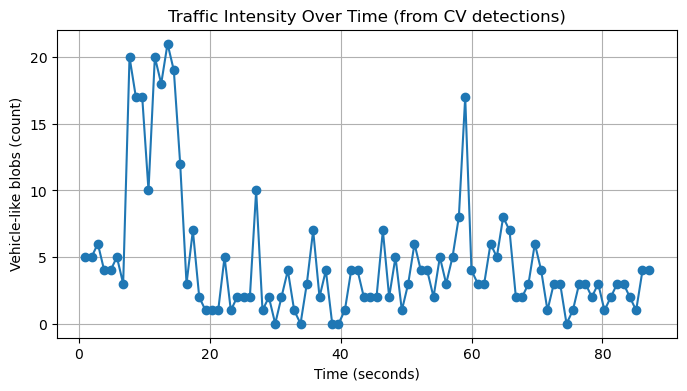

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(df["time_sec"], df["vehicle_like_blobs"], marker="o")
plt.xlabel("Time (seconds)")
plt.ylabel("Vehicle-like blobs (count)")
plt.title("Traffic Intensity Over Time (from CV detections)")
plt.grid(True)
plt.show()

In [27]:
import cv2
import csv
import math

video_path = "data/raw_video/traffic_main.mp4" 

min_area = 800                 
max_distance = 50               

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    raise SystemExit

fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0 or fps is None:
    fps = 30  # fallback
print("FPS used for time:", fps)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Resolution:", width, "x", height)

line_y = height // 2

back_sub = cv2.createBackgroundSubtractorMOG2(
    history=500,
    varThreshold=50,
    detectShadows=True
)

next_id = 0                    
objects = {}                   

csv_file = open("vehicle_crossings.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["vehicle_id", "time_sec", "direction", "cx", "cy"])

total_up = 0      
total_down = 0    
frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    frame_idx += 1
    time_sec = frame_idx / fps

    fg_mask = back_sub.apply(frame)
    _, th = cv2.threshold(fg_mask, 250, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.dilate(clean, kernel, iterations=2)

    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_centroids = []   
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        cx = x + w // 2
        cy = y + h // 2
        current_centroids.append((cx, cy, (x, y, w, h)))

    new_objects = {}

    unmatched_ids = set(objects.keys())

    for (cx, cy, bbox) in current_centroids:
        best_id = None
        best_dist = None
     
        for obj_id in list(unmatched_ids):
            prev_cx = objects[obj_id]["cx"]
            prev_cy = objects[obj_id]["cy"]
            dist = math.hypot(cx - prev_cx, cy - prev_cy)

            if dist <= max_distance and (best_dist is None or dist < best_dist):
                best_dist = dist
                best_id = obj_id

        if best_id is not None:
          
            obj = objects[best_id]
            obj_new = {
                "cx": cx,
                "cy": cy,
                "last_cy": obj["cy"],
                "counted": obj["counted"]
            }
            new_objects[best_id] = obj_new
            unmatched_ids.discard(best_id)
        else:
            
            obj_id = next_id
            next_id += 1
            obj_new = {
                "cx": cx,
                "cy": cy,
                "last_cy": cy,
                "counted": False
            }
            new_objects[obj_id] = obj_new

    objects = new_objects

    for obj_id, obj in objects.items():
        cy = obj["cy"]
        last_cy = obj["last_cy"]

        if obj["counted"]:
            continue 
        
        if last_cy < line_y <= cy:
            total_down += 1
            obj["counted"] = True
            direction = "DOWN" 
            csv_writer.writerow([obj_id, round(time_sec, 2), direction, obj["cx"], obj["cy"]])
       
        elif last_cy > line_y >= cy:
            total_up += 1
            obj["counted"] = True
            direction = "UP"
            csv_writer.writerow([obj_id, round(time_sec, 2), direction, obj["cx"], obj["cy"]])

    cv2.line(frame, (0, line_y), (width, line_y), (255, 0, 0), 2)
  
    for obj_id, obj in objects.items():
        cx, cy = obj["cx"], obj["cy"]
        cv2.circle(frame, (cx, cy), 4, (0, 255, 255), -1)
        cv2.putText(frame, f"ID {obj_id}", (cx + 5, cy - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)


    cv2.putText(frame, f"Up: {total_up}  Down: {total_down}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow("Frame with counting", frame)
    cv2.imshow("Foreground", clean)

    key = cv2.waitKey(1)
    if key == ord('q'):
        print("Interrupted by user.")
        break

cap.release()
csv_file.close()
cv2.destroyAllWindows()
print("Done. Vehicle crossings saved to vehicle_crossings.csv")
print("Total up:", total_up, " Total down:", total_down)

FPS used for time: 29.97002997002997
Resolution: 1280 x 720
Interrupted by user.
Done. Vehicle crossings saved to vehicle_crossings.csv
Total up: 18  Total down: 9
